#### Análisis de una base de datos de venta de CD por Amazon
##### Parte 3: Construyendo un Sistema de Recomendacion con Feedback Implicito

#### **Equipo 28**

#### Alumnos:
#### Gerardo López Colmenares *- A01339657*
#### Jonathan Jesús Marmolejo Hernández *- A01795195*
#### Sarah Mendoza Medina *- A01215352*

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from scipy.sparse import csr_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install implicit

In [ ]:
import implicit

In [ ]:
# Se importa el archivo JSONL sobre información de venta de CDs y Vinylos a través de Amazon.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DIR = "/content/drive/My Drive/BigData/"
os.chdir(DIR)

archivo_jsonl = 'meta_CDs_and_Vinyl.jsonl'
df = pd.read_json(archivo_jsonl, lines=True)

Mounted at /content/drive


In [ ]:
# Entendimiento general de las variables que componen la tabla.
# Selección de variables importantes para el análisis.

df.info()
df.head(5)

# Con base en la información observada, se descartan laas variables sin información relevante o poco informadas.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701959 entries, 0 to 701958
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   main_category    701130 non-null  object 
 1   title            701959 non-null  object 
 2   average_rating   701959 non-null  float64
 3   rating_number    701959 non-null  int64  
 4   features         701959 non-null  object 
 5   description      701959 non-null  object 
 6   price            552650 non-null  object 
 7   images           701959 non-null  object 
 8   videos           701959 non-null  object 
 9   store            701150 non-null  object 
 10  categories       701959 non-null  object 
 11  details          701959 non-null  object 
 12  parent_asin      701959 non-null  object 
 13  bought_together  0 non-null       float64
 14  subtitle         697 non-null     object 
 15  author           464 non-null     object 
dtypes: float64(2), int64(1), object(13)
me

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Digital Music,Release Some Tension,4.6,112,[],[Swv ~ Release Some Tension],12.05,[{'thumb': 'https://m.media-amazon.com/images/...,[],SWV Format: Audio CD,"[CDs & Vinyl, Dance & Electronic, House]","{'Is Discontinued By Manufacturer': 'No', 'Pro...",B000002X4C,NaN,NaN,NaN
1,Digital Music,Rio Angie,5.0,1,[],"[Shrimp City Slim (aka Gary Erwin, b. 1953, Ch...",14.98,[{'thumb': 'https://m.media-amazon.com/images/...,[],Shrimp City Slim (Artist) Format: Audio CD,"[CDs & Vinyl, Jazz, Avant Garde & Free Jazz]",{'Product Dimensions': '5.6 x 0.4 x 4.9 inches...,B00902T10Y,NaN,NaN,NaN
2,Digital Music,Lost in Love,5.0,9,[],[],24.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Nastyboy Klick Format: Audio CD,"[CDs & Vinyl, Rap & Hip-Hop, Gangsta & Hardcore]",{'Package Dimensions': '4.7 x 4.6 x 0.1 inches...,B00000DALY,NaN,NaN,NaN
3,Digital Music,Somewhere in Time,4.8,1186,[],[The 1980 soundtrack to the now classic motion...,11.55,[{'thumb': 'https://m.media-amazon.com/images/...,[],"John Barry (Composer), Barry, John (Comp...","[CDs & Vinyl, Soundtracks, Movie Scores]","{'Is Discontinued By Manufacturer': 'No', 'Lan...",B0000086D1,NaN,NaN,NaN
4,Digital Music,Kimmon Waldruff,5.0,1,[],[Solo acoustic fingerstyle guitar.],14.07,[{'thumb': 'https://m.media-amazon.com/images/...,[],Kimmon Waldruff (Artist) Format: Audio CD,"[CDs & Vinyl, Folk]","{'Is Discontinued By Manufacturer': 'No', 'Pro...",B000S6W7KC,NaN,NaN,NaN


In [ ]:
# Se seleccionan las variables: categoria musical, promedio de evaluación por disco y titulo de disco.
# Con estas tres variables, buscamos determinar los CDs mejor evaluados por las personas que compran en Amazon.

df_base = df[['categories','title','average_rating']]
df_base.rename(columns={'categories':'categorias','title':'titulo','average_rating':'evaluación'}, inplace=True)
df_base.info() #701,959 registros

<ipython-input-8-f7e9462e6cc1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base.rename(columns={'categories':'categorias','title':'titulo','average_rating':'evaluación'}, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701959 entries, 0 to 701958
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   categorias  701959 non-null  object 
 1   titulo      701959 non-null  object 
 2   evaluación  701959 non-null  float64
dtypes: float64(1), object(2)
memory usage: 16.1+ MB


In [ ]:
# Ordenamiento de variables para su correcto análisis.

df_ordenada = df_base.sort_values(by=['evaluación'], ascending=[False])
df_ordenada.head(5)

,categorias,titulo,evaluación
350979,"[CDs & Vinyl, R&B, Soul]",Until You Get Enough of Me,5.0
508032,"[CDs & Vinyl, Jazz, Vocal Jazz]",Not That Different,5.0
617121,"[CDs & Vinyl, Classical]",Die Fledermaus,5.0
234888,"[CDs & Vinyl, Today's Deals in Music, Miscella...",Quilting an American Xmas,5.0
508023,"[CDs & Vinyl, Imports, Classical]",Hall Of Fame,5.0


In [ ]:
# Limpieza de texto en la categoria

#base_top_ord_ind = base_top_ord
base_top_ord_ind = df_ordenada
base_top_ord_ind['categorias2'] = base_top_ord_ind['categorias']
base_top_ord_ind['categorias'] = base_top_ord_ind['categorias'].apply(lambda x: ','.join(x))
base_top_ord_ind['Tipo_musical'] = base_top_ord_ind['categorias'].str.split(',').str[1].str.strip()
base_top_ord_ind.head(5)

,categorias,titulo,evaluación,categorias2,Tipo_musical
350979,"CDs & Vinyl,R&B,Soul",Until You Get Enough of Me,5.0,"[CDs & Vinyl, R&B, Soul]",R&B
508032,"CDs & Vinyl,Jazz,Vocal Jazz",Not That Different,5.0,"[CDs & Vinyl, Jazz, Vocal Jazz]",Jazz
617121,"CDs & Vinyl,Classical",Die Fledermaus,5.0,"[CDs & Vinyl, Classical]",Classical
234888,"CDs & Vinyl,Today's Deals in Music,Miscellaneo...",Quilting an American Xmas,5.0,"[CDs & Vinyl, Today's Deals in Music, Miscella...",Today's Deals in Music
508023,"CDs & Vinyl,Imports,Classical",Hall Of Fame,5.0,"[CDs & Vinyl, Imports, Classical]",Imports


In [ ]:
# Generación de una variable indice que cuente cada registro por categoria.

base_top_ord_ind['Ind_agrupado'] = base_top_ord_ind.groupby('categorias').cumcount() + 1
base_top_ord_ind['Ind_general']  = range(1, len(base_top_ord_ind) + 1)

base_top_ord_ind.head(5)
base_top_ord_ind.info() #142,129 registros

<class 'pandas.core.frame.DataFrame'>
Index: 701959 entries, 350979 to 25080
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   categorias    701959 non-null  object 
 1   titulo        701959 non-null  object 
 2   evaluación    701959 non-null  float64
 3   categorias2   701959 non-null  object 
 4   Tipo_musical  701959 non-null  object 
 5   Ind_agrupado  701959 non-null  int64  
 6   Ind_general   701959 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 42.8+ MB


In [ ]:
# Se genera una variable que contiene el numero de evaluaciones por categoria
# Del total de 142,129 registros evaluados, ahora se tiene una tabla con 54 evaluaciones

conteo_grupo = base_top_ord_ind.groupby('Tipo_musical')['Ind_agrupado'].transform(max) == base_top_ord_ind['Ind_agrupado']
valor = base_top_ord_ind[conteo_grupo]
valor.head(5)

,categorias,titulo,evaluación,categorias2,Tipo_musical,Ind_agrupado,Ind_general
645987,"CDs & Vinyl,2014 Best of the Year So Far- CDs ...",Voyage,5.0,"[CDs & Vinyl, 2014 Best of the Year So Far- CD...",2014 Best of the Year So Far- CDs & Vinyl,1,129502
552505,"CDs & Vinyl,Romantic Music",The Hurry And The Harm,4.8,"[CDs & Vinyl, Romantic Music]",Romantic Music,1,234382
452887,"CDs & Vinyl,Music Coupons",Golden Horns - The Best Of,4.7,"[CDs & Vinyl, Music Coupons]",Music Coupons,2,256556
32914,"CDs & Vinyl,Cobra Entertainment",Jack Frost,4.7,"[CDs & Vinyl, Cobra Entertainment]",Cobra Entertainment,1,292132
453947,"CDs & Vinyl,Indie CD Deals",Too Young To Be In Love,4.6,"[CDs & Vinyl, Indie CD Deals]",Indie CD Deals,4,349779


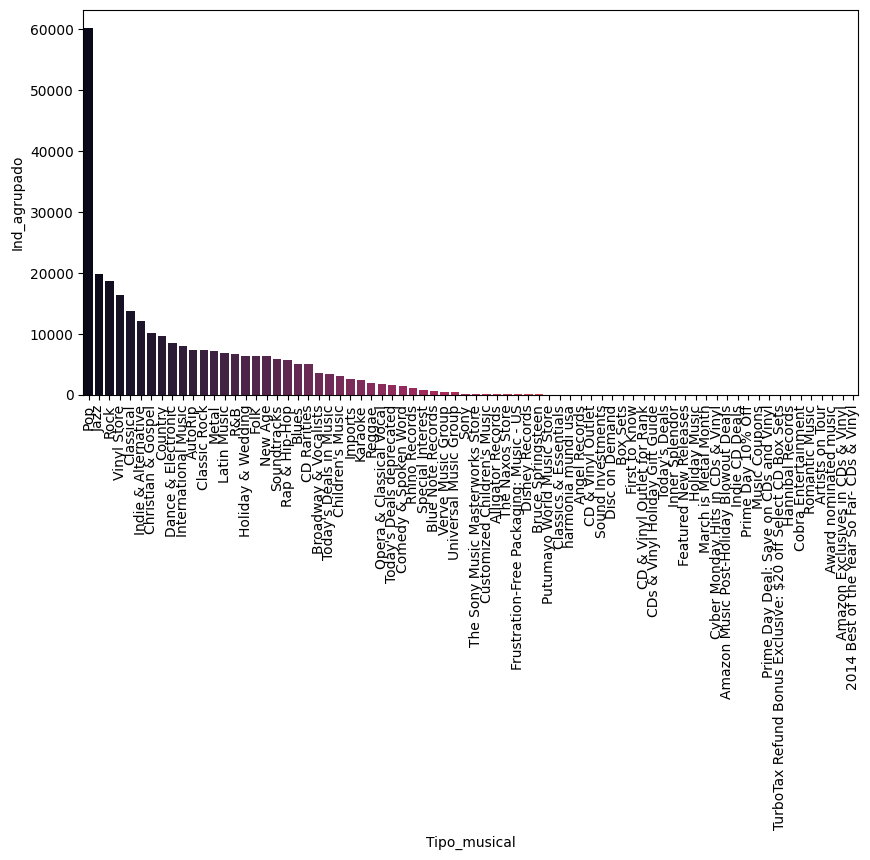

In [ ]:
# Se grafican las categorias de musica con base en su numero de evaluaciones en cada una.

valor = valor.sort_values(by=['Ind_agrupado'], ascending=[False])

plt.figure(figsize=(10,5))
sns.barplot(x='Tipo_musical', y='Ind_agrupado', data=valor, palette='rocket')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Selección de variables por tabla de análisis

BaseRecomendaAgrupada = valor[['Ind_general', 'Ind_agrupado', 'Tipo_musical']]
BaseRecomendaGral = base_top_ord_ind[['Ind_general', 'Tipo_musical', 'titulo', 'evaluación']]
BaseRecomendaAgrupada.head(5)


,Ind_general,Ind_agrupado,Tipo_musical
657254,701955,60172,Pop
194239,701952,19764,Jazz
657369,701948,18665,Rock
595673,701944,16346,Vinyl Store
454732,701925,13794,Classical


In [ ]:
# Cruce de tabla para análisis general

Union = pd.merge(BaseRecomendaGral,BaseRecomendaAgrupada, on='Tipo_musical', how='left')
Union.head(5)
#Union.info() #142,129


,Ind_general_x,Tipo_musical,titulo,evaluación,Ind_general_y,Ind_agrupado
0,1,R&B,Until You Get Enough of Me,5.0,701926,6690
1,2,Jazz,Not That Different,5.0,701952,19764
2,3,Classical,Die Fledermaus,5.0,701925,13794
3,4,Today's Deals in Music,Quilting an American Xmas,5.0,701694,3420
4,5,Imports,Hall Of Fame,5.0,701957,2642


In [ ]:
# Genaración de conteo de personas que evaluan las canciones por estilo de musica.

pre_matriz = Union[['Tipo_musical','Ind_agrupado']]

matriz = pre_matriz.groupby('Tipo_musical').agg({'Ind_agrupado': 'max'})
matriz = matriz.sort_values(by=['Ind_agrupado'], ascending=[False])
dfmatriz = matriz.reset_index()
dfmatriz.head(5)

,Tipo_musical,Ind_agrupado
0,Pop,60172
1,Jazz,19764
2,Rock,18665
3,Vinyl Store,16346
4,Classical,13794


In [ ]:
# Preparación de la base, en donde las columnas son el tipo de estilo musical y las filas son la evaluación obtenida.

valoresBI = dfmatriz['Tipo_musical'].tolist()

for g in valoresBI:
  dfmatriz[g] = dfmatriz['Tipo_musical'].transform(lambda x: int(g in x))

matriz_trab = dfmatriz.drop(['Tipo_musical','Ind_agrupado'], axis=1)

matriz_trab.head(5)

,Pop,Jazz,Rock,Vinyl Store,Classical,Indie & Alternative,Christian & Gospel,Country,Dance & Electronic,International Music,...,TurboTax Refund Bonus Exclusive: $20 off Select CD Box Sets,Hannibal Records,Prime Day Deal: Save on CDs and Vinyl,Music Coupons,Amazon Exclusives in CDs & Vinyl,Cobra Entertainment,Artists on Tour,Award nominated music,Romantic Music,2014 Best of the Year So Far- CDs & Vinyl
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Validación de similitud

from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(matriz_trab, matriz_trab)
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {cosine_sim.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (74, 74)


### En esta base de recomendación se agrupan las canciones por estilo musical, y se ordenan por la calificación más alta hasta la más baja y también por el mayor número de personas que evaluaron la canción.
### Estando al inicio de cada estilo musical, las canciones top a recomendar.

In [ ]:
# Base final de recomendaciones con base en la mejor evaluación por tipo de estilo musical.

BASE_RECOMENDACION = Union[['Tipo_musical', 'titulo', 'evaluación', 'Ind_agrupado']]
BASE_RECOMENDACION.rename(columns={'Tipo_musical':'Estilo', 'titulo':'Nombre_cancion', 'evaluación':'Calificación', 'Ind_agrupado':'Num_evaluadores'}, inplace=True)
BASE_RECOMENDACION = BASE_RECOMENDACION.sort_values(by=['Num_evaluadores', 'Calificación'], ascending=[False, False])
BASE_RECOMENDACION.head(5)
#BASE_RECOMENDACION.info() #142,129


<ipython-input-19-e61d667de291>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BASE_RECOMENDACION.rename(columns={'Tipo_musical':'Estilo', 'titulo':'Nombre_cancion', 'evaluación':'Calificación', 'Ind_agrupado':'Num_evaluadores'}, inplace=True)


,Estilo,Nombre_cancion,Calificación,Num_evaluadores
7,Pop,Smooth Sax Tribute to Michael Jackson's,5.0,60172
19,Pop,Sam Alves,5.0,60172
21,Pop,How Emptiness Sings,5.0,60172
29,Pop,Keep It Together Mini Album,5.0,60172
33,Pop,One Step Ahead,5.0,60172


## En el ejercicio anterior, logramos generar una base que nos ayuda a dar recomendaciones a las personas que compran en Amazon, basados en las evaluaciones que hicieron compradores anteriores.

## El ejercicio anterior se base en un sistema de **Recomendación basado en Items:** *Este enfoque cálcula la similitud entre los items basándose en las calificaciones de los usuarios. Por ejemplo, si dos CD's son calificados de manera similar por muchos usuarios, un CD puede ser recomendado a alguien que gustó el otro o incluso basandonos en la categoria de busqueda.*



#### PARTE 2 - Creando los Mapeos de los titulos de las canciones

In [ ]:
!pip install fuzzywuzzy

In [ ]:
# Funcion encuentra_cancion() que implementa el algoritmo de matching de strings de fuzzywuzzy para hallar el titulo mas parecido
# a partir de un string ingresado por el usuario.

from fuzzywuzzy import process

def encuentra_cancion(title):
    all_titles = BASE_RECOMENDACION['Nombre_cancion'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

# Definición de nombre de uan canción.

title = encuentra_cancion('Sam Alves')
print(f"El titulo correcto de la canción es: {title}")

# Generación de indice para identificar cada nombre de canción.

# Generación de índice para identificar cada nombre de canción.
music_idx = dict(zip(BASE_RECOMENDACION['Nombre_cancion'], BASE_RECOMENDACION.index.tolist()))

# Verifica que el título esté en el diccionario
if title in music_idx:
    indice = music_idx[title]
    print(f"El índice de la canción {title} en la matriz music_idx es: {indice}")

    # Con base en la matriz de relación que generamos previamente y apoyados del índice anterior, podemos encontrar el número de recomendaciones.
    numero_recomendaciones = 3
    sim_scores = list(enumerate(cosine_sim[indice]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(numero_recomendaciones + 1)]
    similar_music = [BASE_RECOMENDACION.iloc[i[0]]['Nombre_cancion'] for i in sim_scores]

    print(f"Porque escuchaste la canción {title}, te pueden interesar las siguientes {numero_recomendaciones} canciones:")
    for song in similar_music:
        print(song)
else:
    print(f"No se encontró la canción {title} en la matriz music_idx.")

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


El titulo correcto de la canción es: Sam Alves
El índice de la canción Sam Alves en la matriz music_idx es: 19
Porque escuchaste la canción Sam Alves, te pueden interesar las siguientes 3 canciones:
Smooth Sax Tribute to Michael Jackson's
Sam Alves
How Emptiness Sings


In [ ]:
def obtener_recomendaciones_basadas_contenido(title_string, numero_recomendaciones=10):
    title = encuentra_cancion(title_string)
    if title in music_idx:
        idx = music_idx[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:(numero_recomendaciones+1)]
        similar_music = [i[0] for i in sim_scores]
        print(f"Las canciones recomendadas con base en la canción '{title}' son:")
        print(BASE_RECOMENDACION['Nombre_cancion'].iloc[similar_music])
    else:
        print(f"No se encontró la canción '{title}' en la matriz music_idx.")


In [ ]:
obtener_recomendaciones_basadas_contenido('Sam Alves', 5)

Las canciones recomendadas con base en la canción 'Sam Alves' son:
7     Smooth Sax Tribute to Michael Jackson's
19                                  Sam Alves
21                        How Emptiness Sings
29                Keep It Together Mini Album
33                             One Step Ahead
Name: Nombre_cancion, dtype: object


#### PARTE 3 - Construyendo el modelo de modelo de Recomendacion de Feedback Implicito

In [ ]:
#Partimos de la base de recomendación:

Union.head(5)

,Ind_general_x,Tipo_musical,titulo,evaluación,Ind_general_y,Ind_agrupado
0,1,R&B,Until You Get Enough of Me,5.0,701926,6690
1,2,Jazz,Not That Different,5.0,701952,19764
2,3,Classical,Die Fledermaus,5.0,701925,13794
3,4,Today's Deals in Music,Quilting an American Xmas,5.0,701694,3420
4,5,Imports,Hall Of Fame,5.0,701957,2642


In [ ]:
#Esta matriz dispersa usuario-item es una matriz que se obtiene al usar scipy.sparse.csr_matrixque almacena los datos de una manera dispersa.

def create_X(df: pd.DataFrame):

    N = df['Ind_agrupado'].nunique()
    M = df['Ind_general_x'].nunique()

    user_mapper = dict(zip(np.unique(df["Ind_agrupado"]), list(range(N))))
    music_mapper = dict(zip(np.unique(df["Ind_general_x"]), list(range(M))))

    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["Ind_agrupado"])))
    music_inv_mapper = dict(zip(list(range(M)), np.unique(df["Ind_general_x"])))

    user_index = [user_mapper[i] for i in df['Ind_agrupado']]
    music_index = [music_mapper[i] for i in df['Ind_general_x']]

    X = csr_matrix((df["evaluación"], (music_index, user_index)), shape=(M, N))

    return X, user_mapper, music_mapper, user_inv_mapper, music_inv_mapper

In [ ]:
X, user_mapper, music_mapper, user_inv_mapper, music_inv_mapper = create_X(Union)

In [ ]:
# Se crean los mapeos de los titulos de las canciones

from fuzzywuzzy import process

def music_finder(title):
    all_titles = Union['titulo'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

music_title_mapper = dict(zip(Union['titulo'], Union['Ind_general_x']))
music_title_inv_mapper = dict(zip(Union['Ind_general_x'], Union['titulo']))

def get_music_index(title):
    fuzzy_title = music_finder(title)
    music_id = music_title_mapper[fuzzy_title]
    music_idx = music_mapper[music_id]
    return music_idx

def get_music_title(music_idx):
    music_id = music_inv_mapper[music_idx]
    title = music_title_inv_mapper[music_id]
    return title

In [ ]:
#Probamos la función para obtener el indice.
get_music_index('Sam Alves')

19

In [ ]:
#Probamos la función para obtener el nombre de la canción con base en el indice previamente obtenido.
get_music_title(19)

'Sam Alves'

In [ ]:
# La libreria implicit implementa una factorizacion matricial utilizando ALS

import implicit
model = implicit.als.AlternatingLeastSquares(factors=50)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [ ]:
#Se ajusta nuestro modelo a la matriz user-item.

model.fit(X.T.tocsr())

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
music_of_interest = 'Sam Alves'
music_index = get_music_index(music_of_interest)

In [ ]:
related = model.similar_items(music_index)
related

(array([    19,  58956, 289341, 234544, 427029,  99505, 493343, 157413,
        574541, 494500], dtype=int32),
 array([1.0000001 , 0.9999944 , 0.99999434, 0.9999943 , 0.9999942 ,
        0.9999937 , 0.9999936 , 0.99999356, 0.999993  , 0.99999297],
       dtype=float32))

In [ ]:
print(f"Por que escuchaste la canción de {music_finder(music_of_interest)} te pueden interesar las siguientes canciones:")
for t, r in zip(related[0], related[1]):

    recommended_title = get_music_title(t)
    if recommended_title != music_finder(music_of_interest):
        print(recommended_title)

Por que escuchaste la canción de Sam Alves te pueden interesar las siguientes canciones:
David Carroll Galaxy
Sky at Night
Skinny Boy
Sings for Playboys
Reckless Devotion
Boro Song
Drops Of JupiterMy Private Nation
Only Soul: 1985-1989 Series
Freak Puke


PARTE 4 - Construyendo el modelo de modelo de Recomendacion - Generando las recomendaciones del usuario

In [ ]:
#Partimos de la base de recomendación:

Union.head(5)

,Ind_general_x,Tipo_musical,titulo,evaluación,Ind_general_y,Ind_agrupado
0,1,R&B,Until You Get Enough of Me,5.0,701926,6690
1,2,Jazz,Not That Different,5.0,701952,19764
2,3,Classical,Die Fledermaus,5.0,701925,13794
3,4,Today's Deals in Music,Quilting an American Xmas,5.0,701694,3420
4,5,Imports,Hall Of Fame,5.0,701957,2642


In [ ]:
# Generamos una nueva tabla, en donde contamos el número de canciones que contiene cada tipo musical.

Num_canciones = Union[['Tipo_musical','titulo']]

Conteo = Num_canciones.groupby('Tipo_musical').size().reset_index(name='conteo')
Conteo.head(5)

# Unimos el conteo con la tabla original
Union2 = Union.merge(Conteo, on='Tipo_musical')
Union2.head(5)

# Ahora ya tenemos un indicador que nos ayudará a informar cuantas canciones similares al tipo de musica buscado, se pueden recomendar.

,Ind_general_x,Tipo_musical,titulo,evaluación,Ind_general_y,Ind_agrupado,conteo
0,1,R&B,Until You Get Enough of Me,5.0,701926,6690,16116
1,39,R&B,Letter from Eye to I,5.0,701926,6690,16116
2,84,R&B,For Sentimental Reasons: The Love Songs,5.0,701926,6690,16116
3,144,R&B,Mixfit Mindz,5.0,701926,6690,16116
4,211,R&B,Emotions,5.0,701926,6690,16116


In [ ]:
#Ordenamos los valores

Union_ordenada=Union2.sort_values(by=['Tipo_musical', 'evaluación'], ascending=[False, False])
Union_ordenada.head(5)

,Ind_general_x,Tipo_musical,titulo,evaluación,Ind_general_y,Ind_agrupado,conteo
700932,4010,harmonia mundi usa,"Orgues Historiques/D'Espagne - Trujillo, Covar...",5.0,648641,44,44
700933,9261,harmonia mundi usa,Orgues Historiques/Espagne Spanish historical ...,5.0,648641,44,44
700934,13503,harmonia mundi usa,"Maria Yudina Plays Schubert Impromptus, Op.90,...",5.0,648641,44,44
700935,14729,harmonia mundi usa,Die Zauberflote -Spec.Edi,5.0,648641,44,44
700936,17793,harmonia mundi usa,Messe à l'Usage des Paroisses,5.0,648641,44,44


In [ ]:
#Generamos una nueva matriz para adaptar nuestra nueva busqueda.

def create_X2(df: pd.DataFrame):

    N = df['conteo'].nunique()
    M = df['Tipo_musical'].nunique()

    user_mapper2 = dict(zip(np.unique(df["conteo"]), list(range(N))))
    music_mapper2 = dict(zip(np.unique(df["Tipo_musical"]), list(range(M))))

    user_inv_mapper2 = dict(zip(list(range(N)), np.unique(df["conteo"])))
    music_inv_mapper2 = dict(zip(list(range(M)), np.unique(df["Tipo_musical"])))

    Union_ordenada["Ind_general_y"] = Union_ordenada["Ind_general_y"].astype(int)

    user_index2 = [user_mapper2[i] for i in df['conteo']]
    music_index2 = [music_mapper2[i] for i in df['Tipo_musical']]

    X2 = csr_matrix((df["Ind_general_y"], (music_index2, user_index2)), shape=(M, N))

    return X2, user_mapper2, music_mapper2, user_inv_mapper2, music_inv_mapper2

In [ ]:
X2, user_mapper2, music_mapper2, user_inv_mapper2, music_inv_mapper2 = create_X2(Union_ordenada)

In [ ]:
# Se crean los mapeos de los titulos de las canciones

from fuzzywuzzy import process

def music_finder(title):
    all_titles = Union_ordenada['titulo'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

music_title_mapper2 = dict(zip(Union_ordenada['titulo'], Union_ordenada['conteo']))

def get_music_conteo(title):
    fuzzy_title = music_finder(title)
    music_id2 = music_title_mapper2[fuzzy_title]
    music_idx2 = user_mapper2[music_id2]
    return music_idx2

music_title_mapper3 = dict(zip(Union_ordenada['titulo'], Union_ordenada['Tipo_musical']))

def get_music_tipo(title):
    fuzzy_title = music_finder(title)
    music_id3 = music_title_mapper3[fuzzy_title]
    music_idx3 = music_mapper2[music_id3]
    #return music_idx3
    return music_id3


In [ ]:
# Valores de prueba
cancion_de_interes = 'Sam Alves'

In [ ]:
#Probamos la función para obtener el conteo.
conteo=get_music_conteo('Sam Alves')

In [ ]:
conteo

60

In [ ]:
#Probamos la función para obtener el tipo.
tipo=get_music_tipo('Sam Alves')

In [ ]:
tipo

'Pop'

##### Ahora con todos los datos recabados, podemo hacer nuestra nueva recomendación, con base en el tipo de canción y las mejores evaluadas por otros clientes.

In [ ]:
# Realizamos la sugenrencia
print(f"Si te gusta la canción: {cancion_de_interes}, exiten {conteo} más que te pueden agradar porqué son del mismo estilo: {tipo}")
print(f"Te recomendamos las 5 mejor evaluadas de este tipo por los usuarios:")

Si te gusta la canción: Sam Alves, exiten 60 más que te pueden agradar porqué son del mismo estilo: Pop
Te recomendamos las 5 mejor evaluadas de este tipo por los usuarios:


In [ ]:
# Filtramos los valores.
Filtropre = Union_ordenada[Union_ordenada['Tipo_musical'] == tipo]
Filtro = Filtropre['titulo']
Filtro.head(5)

229306    Smooth Sax Tribute to Michael Jackson's
229307                                  Sam Alves
229308                        How Emptiness Sings
229309                Keep It Together Mini Album
229310                             One Step Ahead
Name: titulo, dtype: object